In [1]:
import numpy as np
import pandas as pd

import random

import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow import keras

from keras.layers import Dense # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.models import model_from_json # saving and loading trained model
from keras.layers import Dropout, Activation

from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model

from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu, "\n")
else:
  print("No GPU device found")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') 



In [3]:
!nvidia-smi

Sun Feb 26 09:15:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   43C    P8    11W / 200W |   7100MiB /  8192MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#Loading Secondary Data

import glob

path = r'H:/Datasets/CIC-DDoS2019/03-11' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

p = 0.20  # 20% of the lines

#For First Day Data
for filename in all_files:
    df = pd.read_csv(filename, low_memory=False)
    #df = pd.read_csv(filename, skiprows=lambda i: i>0 and random.random() > p, low_memory=False)
    li.append(df)
    print("Read Completed for ", filename)
    
#For Second Day Data
path = r'H:/Datasets/CIC-DDoS2019/01-12' # use your path
all_files = glob.glob(path + "/*.csv")

for filename in all_files:
    df = pd.read_csv(filename, low_memory=False)
    li.append(df)
    print("Read Completed for ", filename)



df = pd.concat(li, axis=0, ignore_index=True)

print("Finished Reading all data...")

Read Completed for  H:/Datasets/CIC-DDoS2019/03-11\LDAP.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/03-11\MSSQL.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/03-11\NetBIOS.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/03-11\Portmap.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/03-11\Syn.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/03-11\UDP.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/03-11\UDPLag.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/01-12\DrDoS_DNS.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/01-12\DrDoS_LDAP.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/01-12\DrDoS_MSSQL.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/01-12\DrDoS_NetBIOS.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/01-12\DrDoS_NTP.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/01-12\DrDoS_SNMP.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/01-12\DrDoS_SSDP.csv
Read Completed for  H:/Datasets/CIC-DDoS2019/01-12\DrDoS_UDP.csv
Read Completed for  H:/Datasets/CIC-DDoS2019

In [5]:
print(df.shape)

(70427637, 88)


In [6]:
df=df.drop('Unnamed: 0',axis=1)

overfitting_columns = [' Source IP', ' Destination IP', ' Source Port', ' Destination Port', ' Timestamp', 'SimillarHTTP', 'Flow ID', ' Fwd URG Flags', ' Bwd URG Flags', 'FIN Flag Count', ' PSH Flag Count', ' ECE Flag Count', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
df.drop(labels=overfitting_columns, axis='columns', inplace=True)

print("columns: ", len(df.columns))
df.columns

columns:  69


Index([' Protocol', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       ' SYN Flag Count', ' RST Flag Count', ' ACK F

In [7]:
df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
0,17,1,2,0,422.0,0.0,211.0,211.0,211.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NetBIOS
1,17,48,2,0,530.0,0.0,265.0,265.0,265.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NetBIOS
2,17,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NetBIOS
3,17,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NetBIOS
4,17,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,NetBIOS


In [8]:
df = df.rename(columns={' Label': 'Label'})
df["Label"].value_counts()

TFTP             20082580
Syn               6473789
MSSQL             5787453
DrDoS_SNMP        5159870
DrDoS_DNS         5071011
DrDoS_MSSQL       4522492
DrDoS_NetBIOS     4093279
UDP               3867155
NetBIOS           3657497
DrDoS_UDP         3134645
DrDoS_SSDP        2610611
DrDoS_LDAP        2179930
LDAP              1915122
DrDoS_NTP         1202642
UDP-lag            366461
Portmap            186960
BENIGN             113828
UDPLag               1873
WebDDoS               439
Name: Label, dtype: int64

In [9]:
from scipy.stats import zscore

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

In [10]:
analyze(df)


70427637 rows
**  Protocol:[17:90.02%,6:9.98%,0:0.01%]
**  Flow Duration:1559518 (2%)
**  Total Fwd Packets:853 (0%)
**  Total Backward Packets:464 (0%)
** Total Length of Fwd Packets:6880 (0%)
**  Total Length of Bwd Packets:6359 (0%)
**  Fwd Packet Length Max:2593 (0%)
**  Fwd Packet Length Min:1494 (0%)
**  Fwd Packet Length Mean:13541 (0%)
**  Fwd Packet Length Std:14454 (0%)
** Bwd Packet Length Max:1331 (0%)
**  Bwd Packet Length Min:244 (0%)
**  Bwd Packet Length Mean:9866 (0%)
**  Bwd Packet Length Std:10295 (0%)
** Flow Bytes/s:2025897 (2%)
**  Flow Packets/s:1875617 (2%)
**  Flow IAT Mean:2146803 (3%)
**  Flow IAT Std:6524954 (9%)
**  Flow IAT Max:1169346 (1%)
**  Flow IAT Min:4489 (0%)
** Fwd IAT Total:1549706 (2%)
**  Fwd IAT Mean:2124296 (3%)
**  Fwd IAT Std:6495841 (9%)
**  Fwd IAT Max:1154408 (1%)
**  Fwd IAT Min:1273 (0%)
** Bwd IAT Total:317253 (0%)
**  Bwd IAT Mean:319797 (0%)
**  Bwd IAT Std:321940 (0%)
**  Bwd IAT Max:313590 (0%)
**  Bwd IAT Min:169 (0%)
** Fwd PSH

<Figure size 1440x1440 with 0 Axes>

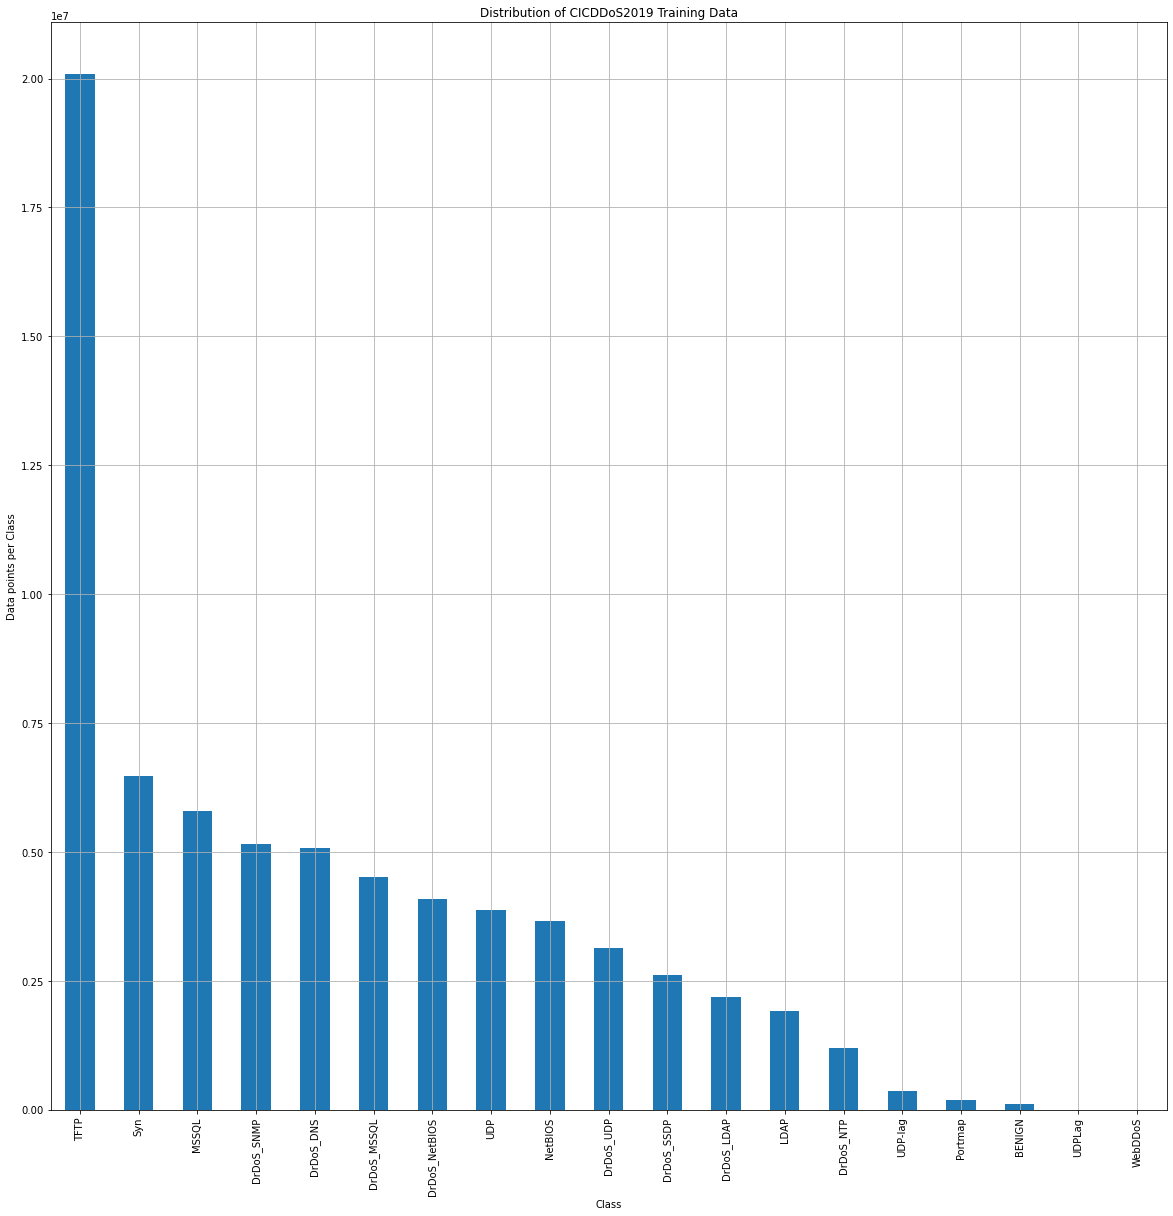

In [11]:
from matplotlib.pyplot import *

plt.figure(figsize=(20,20))

fig, ax = plt.subplots(figsize=(20,20))

class_distribution = df['Label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of CICDDoS2019 Training Data')
plt.grid()
plt.show()

fig.savefig('CIC-DDoS2019_Data_Distribution.pdf') 

In [12]:
# Before Cleaning Data set for Duplicate
sorted_ds = np.argsort(-class_distribution.values)
for i in sorted_ds:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/df.shape[0]*100), 3), '%)')

Number of data points in class TFTP : 20082580 ( 28.515 %)
Number of data points in class Syn : 6473789 ( 9.192 %)
Number of data points in class MSSQL : 5787453 ( 8.218 %)
Number of data points in class DrDoS_SNMP : 5159870 ( 7.326 %)
Number of data points in class DrDoS_DNS : 5071011 ( 7.2 %)
Number of data points in class DrDoS_MSSQL : 4522492 ( 6.421 %)
Number of data points in class DrDoS_NetBIOS : 4093279 ( 5.812 %)
Number of data points in class UDP : 3867155 ( 5.491 %)
Number of data points in class NetBIOS : 3657497 ( 5.193 %)
Number of data points in class DrDoS_UDP : 3134645 ( 4.451 %)
Number of data points in class DrDoS_SSDP : 2610611 ( 3.707 %)
Number of data points in class DrDoS_LDAP : 2179930 ( 3.095 %)
Number of data points in class LDAP : 1915122 ( 2.719 %)
Number of data points in class DrDoS_NTP : 1202642 ( 1.708 %)
Number of data points in class UDP-lag : 366461 ( 0.52 %)
Number of data points in class Portmap : 186960 ( 0.265 %)
Number of data points in class BEN

In [13]:
# Data Cleaning

# Checking for NULL values
print('Null values in dataset are',len(df[df.isnull().any(1)]))
print('='*40)

# Checkng for DUPLICATE values
df.drop_duplicates(keep='first', inplace = True)

# For now, just drop NA's (rows with missing values)
df.dropna(inplace=True,axis=1) 

# stored the data into a pickle file so we can load through
# df.to_pickle('df.pkl')

print("Read {} rows.".format(len(df)))

Null values in dataset are 249152
Read 10457147 rows.


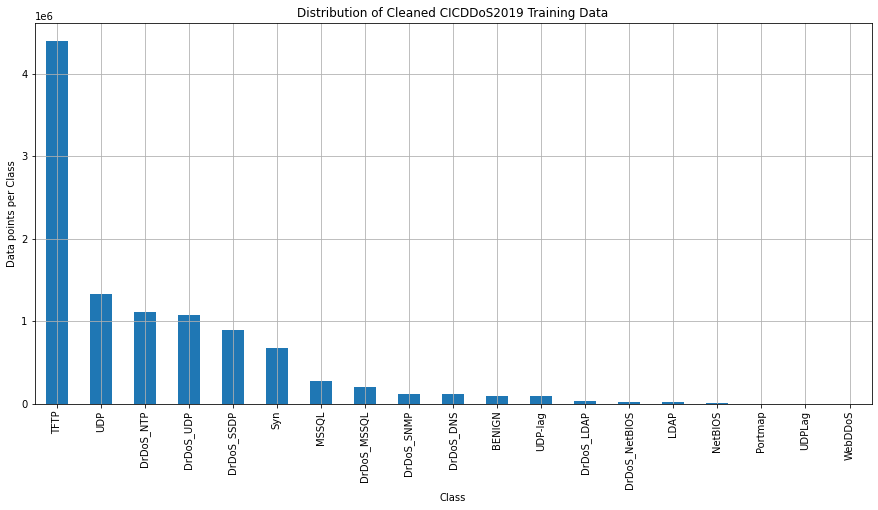

In [14]:
from matplotlib.pyplot import *

plt.figure(figsize=(15,7))
class_distribution = df['Label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Cleaned CICDDoS2019 Training Data')
plt.grid()
plt.show()

In [15]:
# After Cleaning Data set for Duplicate
sorted_ds = np.argsort(-class_distribution.values)
for i in sorted_ds:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/df.shape[0]*100), 3), '%)')

Number of data points in class TFTP : 4396777 ( 42.046 %)
Number of data points in class UDP : 1327526 ( 12.695 %)
Number of data points in class DrDoS_NTP : 1112904 ( 10.643 %)
Number of data points in class DrDoS_UDP : 1075330 ( 10.283 %)
Number of data points in class DrDoS_SSDP : 891221 ( 8.523 %)
Number of data points in class Syn : 681343 ( 6.516 %)
Number of data points in class MSSQL : 272252 ( 2.604 %)
Number of data points in class DrDoS_MSSQL : 207003 ( 1.98 %)
Number of data points in class DrDoS_SNMP : 114185 ( 1.092 %)
Number of data points in class DrDoS_DNS : 113259 ( 1.083 %)
Number of data points in class BENIGN : 95881 ( 0.917 %)
Number of data points in class UDP-lag : 89056 ( 0.852 %)
Number of data points in class DrDoS_LDAP : 30099 ( 0.288 %)
Number of data points in class DrDoS_NetBIOS : 19490 ( 0.186 %)
Number of data points in class LDAP : 17894 ( 0.171 %)
Number of data points in class NetBIOS : 10420 ( 0.1 %)
Number of data points in class Portmap : 1638 ( 0

In [16]:
data = df.iloc[:,1:-1]

In [17]:
label_encoder = LabelEncoder()
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')

In [18]:
corr = data.corr()

<AxesSubplot:>

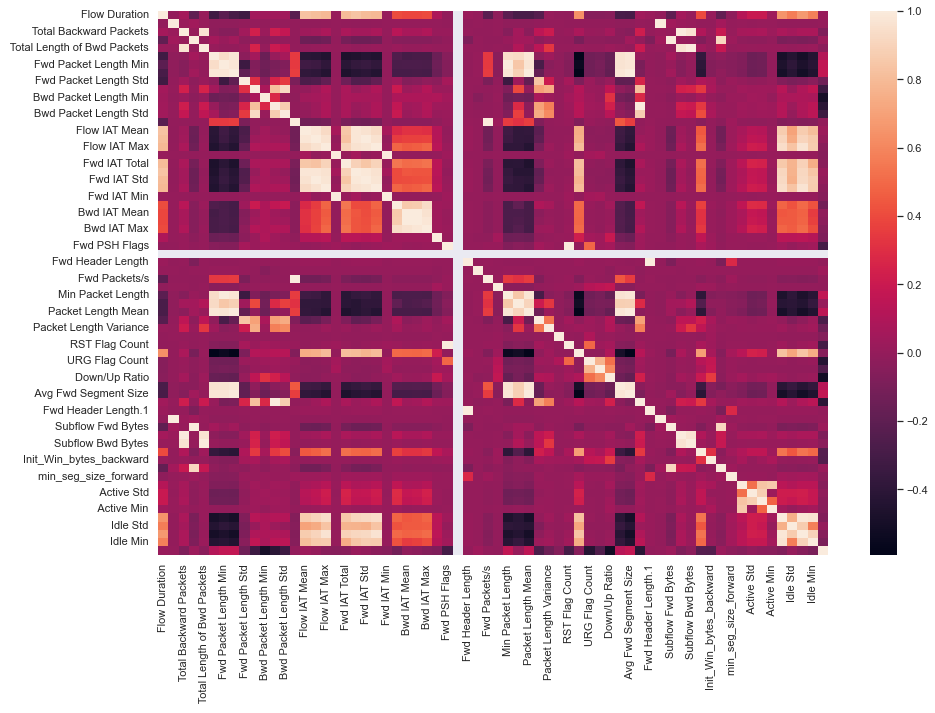

In [19]:
import seaborn as sns

sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(corr)

In [20]:
print(df.columns)

Index([' Protocol', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Flow Packets/s', ' Flow IAT Mean',
       ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total',
       ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min',
       'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max',
       ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', ' SYN Flag Count',
       ' RST Flag Count', ' ACK Flag Count', ' UR

In [21]:
#drop na values and reset index
data_clean = df.dropna().reset_index()

# label encoding
labelencoder = LabelEncoder()
data_clean['Label'] = labelencoder.fit_transform(data_clean['Label'])

data_clean['Label'].value_counts()

14    4396777
15    1327526
4     1112904
8     1075330
7      891221
13     681343
10     272252
3      207003
6      114185
1      113259
0       95881
16      89056
2       30099
5       19490
9       17894
11      10420
12       1638
17        455
18        414
Name: Label, dtype: int64

In [22]:
data_np = data_clean.to_numpy(dtype="float32")
data_np = data_np[~np.isinf(data_np).any(axis=1)]

del df

X = data_np[:, 0:67]

enc = OneHotEncoder()

Y = enc.fit_transform(data_np[:,68:]).toarray()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.25, random_state=2, shuffle=True)


_features = X.shape[1]
n_classes = Y.shape[1]

print('X.shape = ',X.shape)
print('Y.shape = ',Y.shape)
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', Y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',Y_test.shape)

X.shape =  (10411613, 67)
Y.shape =  (10411613, 19)
X_train.shape =  (7808709, 67)
y_train.shape =  (7808709, 19)
X_test.shape =  (2602904, 67)
y_test.shape =  (2602904, 19)


In [23]:
del data_np
del data_clean

# DNN

In [24]:
from tensorflow.keras.callbacks import EarlyStopping


# Simple 3 Layer Dense Model
model = Sequential()
model.add(Dense(128, input_dim=_features, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_classes, kernel_initializer='normal'))
model.add(Dense(n_classes, activation = 'softmax'))
model.summary() 

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='BinaryCrossentropy', optimizer=opt, metrics=['accuracy'])

early_stop_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=3, min_lr=0.001)
    
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=30,
                              verbose=True, #,callbacks=[reduce_lr, early_stop_callback],
                              validation_data=(X_test, Y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               8704      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 19)                2

In [25]:
model.save('H:/Datasets/CIC-DDoS2019/first_model_dnn.h5')

In [26]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing

start = dt.datetime.now()

escore = model.evaluate(X_test, Y_test, batch_size=32)
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)
#roc_auc_socre = multiclass_roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

81341/81341 [==============================] - 63s 767us/step


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Completed
Time taken: 0:03:51.756136
Validation score: 0.9979240596195634
Evaluation score: [0.0007743812166154385, 0.9979240404319763]
Recall score: 0.9979240596195634
Precision score: 0.9979264951106068
F1 Measure score: 0.9979240417850446
ROC-AUC score: 0.940128860819773


In [27]:
# Plot for training and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

In [28]:
import time

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

81341/81341 [==============================] - 62s 756us/step
Inference time: 83.75 seconds


In [29]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[  23601,      39,       0,       7,      55,       3,       3,
              1,       9,       4,       4,       1,      10,      22,
            152,       0,       1,       0,       0],
       [     56,   26192,       0,       0,       0,       3,       0,
              0,       0,       0,       0,       0,       0,       1,
              0,       6,       0,       0,       0],
       [     14,      40,    7363,       0,       0,       2,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0],
       [     10,      13,      18,   48482,       1,       0,       0,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0],
       [     46,       1,       0,       0,  277967,       8,      42,
              0,       0,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0],
       [     10,    

In [30]:
start_by_epoch = 1
epochs = range(start_by_epoch, len(loss_values) + 1)

In [ ]:
plt.plot(epochs, acc[start_by_epoch-1:], label='Training accuracy')
plt.plot(epochs, val_acc[start_by_epoch-1:], label='Validation accuracy')
plt.title('DNN: Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Test'], loc='lower right')

plt.show()
plt.clf()

In [ ]:
plt.plot(epochs, loss_values[start_by_epoch-1:], label='Training Loss')
plt.plot(epochs, val_loss_values[start_by_epoch-1:], label='Validation Loss')
plt.title('DNN: Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()

plt.show()
plt.clf()

In [ ]:
cf_matrix = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cf_matrix)

labels = ['TFTP','DrDoS_SNMP','DrDoS_DNS','DrDoS_MSSQL','DrDoS_NetBIOS','DrDoS_UDP','DrDoS_SSDP','Syn',
          'DrDoS_LDAP','DrDoS_NTP','MSSQL','UDP','NetBIOS','LDAP','UDP-lag','BENIGN','Portmap','WebDDoS','UDPLag']

#plt.figure(figsize=(20,15))
#sn.set(font_scale=1.4)
sn.set(rc = {'figure.figsize':(15,10)})
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')

#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show()  

# DCNN

In [34]:
# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D
from sklearn import metrics
from hyperopt import fmin, hp, tpe, Trials, STATUS_OK
from hyperopt.plotting import main_plot_history, main_plot_vars
import uuid
import gc
from tensorflow import keras
import tensorflow as tf

K = keras.backend

X_train = X_train.reshape(X_train.shape[0], _features, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], _features, 1).astype('float32')


# DCNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, input_shape=(_features, 1)))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(filters=256, kernel_size=6))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(filters=128, kernel_size=6))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(96, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_classes, activation = 'softmax'))
model.summary() 

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

early_stop_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=3, min_lr=0.0001)
    
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=30,
                              verbose=True, #callbacks=[reduce_lr, early_stop_callback],
                              validation_data=(X_test, Y_test))  

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 62, 128)           896       
                                                                 
 activation (Activation)     (None, 62, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 31, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 256)           196864    
                                                                 
 activation_1 (Activation)   (None, 26, 256)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 256)          0         
 1D)                                                  

In [35]:
model.save('H:/Datasets/CICDDoS2020/model_cnn.h5')

In [36]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing

start = dt.datetime.now()

escore = model.evaluate(X_test, Y_test, batch_size=32)
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)
#roc_auc_socre = multiclass_roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

81341/81341 [==============================] - 111s 1ms/step


C:\Users\Maruata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Completed
Time taken: 0:05:06.521692
Validation score: 0.9986371379659027
Evaluation score: [0.002468891330063343, 0.9986371247673035]
Recall score: 0.9986371379659027
Precision score: 0.9986354296524001
F1 Measure score: 0.9986365855345629
ROC-AUC score: 0.9276053320390522


In [37]:
# Plot for training and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

In [38]:
import time

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

81341/81341 [==============================] - 110s 1ms/step
Inference time: 131.95 seconds


In [39]:
pred.shape
y_test.shape

(2602904,)

In [40]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[  23992,      48,       1,       1,      37,       2,       8,
              1,       2,       1,       7,       2,       9,     127,
              0,       0,       0,       0,       0],
       [      0,   26883,       0,       0,       1,       0,       0,
              0,       2,       0,       0,       0,       0,      13,
              0,      64,       0,       0,       0],
       [      0,       0,    7009,       0,       0,       0,      12,
              0,       0,       0,       0,       0,       0,      10,
              0,       0,       0,       0,       0],
       [      0,      34,      12,   483593,      12,       0,       0,
              0,       0,       0,       0,       0,       0,       1,
              1,       0,       0,       0,       0],
       [      0,       0,       0,       0,  277913,      13,      66,
              3,       0,       0,       0,       0,       0,       5,
              2,       0,       0,       0,       0],
       [      0,   

In [ ]:
cf_matrix = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(cf_matrix)

labels = ['TFTP','DrDoS_SNMP','DrDoS_DNS','DrDoS_MSSQL','DrDoS_NetBIOS','DrDoS_UDP','DrDoS_SSDP','Syn',
          'DrDoS_LDAP','DrDoS_NTP','MSSQL','UDP','NetBIOS','LDAP','UDP-lag','BENIGN','Portmap','WebDDoS','UDPLag']

#plt.figure(figsize=(20,15))
#sn.set(font_scale=1.4)
sn.set(rc = {'figure.figsize':(15,10)})
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')

#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show()  